# Tutorials 3: Stochastic inverse Poisson problem

In previous numerical analysis/CFD courses, you may have solved Poisson's equation (for example for the pressure in an incompressible Navier-Stokes code).  In this project you will solve an *inverse* Poisson problem: given some observations of the *solution* ($u$) of the equation, you will approximate the spatially varying diffusion coeffient $\alpha$ in the equation that leads to that specific $u$.  Specifically we consider Poisson's equation in 1d with a diffusion coefficient $\alpha(x)$, and source term $f(x)$:
$$
\frac{\partial}{\partial x} \left( \alpha(x) \frac{\partial u}{\partial x}\right) = f(x),\quad\mathrm{on}\:\:[0, 1]
$$
with Dirichlet boundary conditions
$$
u(0) = U_0 = 1,\quad u(1) = U_1 = 6.
$$
In addition we assume the $\alpha(0) = \alpha(1) = 1$ is known.  Thoughout the RHS $f(x) \equiv 0$ - but you can choose non-zero $f$, to see how results change.

This tutorial will take you through the following 3 steps:

1. **Forward problem**: Discretize PDE and solve for known $\alpha(x)$ (a prerequiste for the inverse problem!).
1. **Bayesian modelling**: Build a statistical model for the data-simulation problem.
1. **Posterior sampling**: Markov-chain Monte-Carlo sampling of the posterior for $\alpha$. 

In [139]:
%matplotlib inline
import copy, pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, linregress
import scipy.stats as stats
from scipy.optimize import minimize
from scipy.io import loadmat
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

## 1. Forward problem: Finite-difference discretization

We will use a finite-difference discretization on a uniform mesh. The computational domain $\Omega=[0, 1]$ is divided into $N$ sub-intervals $[x_i, x_{i+1}]$ with $x_i:=\frac{1}{N}i$, with spacing $h:=x_{i+1}-x_i=\frac{1}{N}$.  We write $\hat u$ for the discretization of $u$ at the grid nodes, $\hat\alpha$ and $\hat f$ similarly.  Note that, in the following the subscript $i$ always indicates a value at a grid *node* $x_i$.  A central discretization is used, giving:
$$
  \left(\frac{\hat \alpha_{i+1}+\hat \alpha_i}{2}\right)\frac{\hat u_{i+1}-\hat u_i}{h^2} - \left(\frac{\hat \alpha_i+\hat \alpha_{i-1}}{2}\right)\frac{\hat u_i-\hat u_{i-1}}{h^2} = \hat f_i, \quad \forall i\in\{1,\dots,N-1\}
$$
at each interior grid point.  On the boundaries, the Dirichlet conditions are enforced explicitly:
$$
\hat u_0 = U_0, \quad \hat u_N = U_1.
$$
This discretization is stable, and results in a tridiagonal linear system for $\hat u := [u_0,\dots,u_N] \in\mathbb{R}^{N+1}$:
$$
A(\hat{\alpha}) \cdot\hat{u}  = \hat{f},
$$
where $A(\boldsymbol{\alpha})$ is the system matrix, which may be solved easily (in this 1d case) by direct inversion using the Thomas algorithm.  We will also refer to the discrete system as $\mathcal{R}$, defined as:
$$
\mathcal{R}(\hat{u};\hat{\alpha}) := A(\hat{\alpha}) \cdot\hat{u}  - \hat{f} = 0.
$$

In [140]:
def poisson_matrix(alpha):
    """
    Compute the tri-diagonal Poisson matrix on domain x \in [0,1], assuming uniform grid.
    
    Args:
        alpha (array): Value of dissipation coefficient at every grid node.  Shape (N+1,).
    Return:
        A (sparse matrix): 
    """
    N = alpha.shape[0] -1
    h     = 1./N
    scale = 1./(2.*h**2)
    diag, upper, lower = np.ones(N+1), np.zeros(N), np.zeros(N) 
    upper[1:]  =  scale * (alpha[1:-1]                  + alpha[2:  ])
    diag[1:-1] = -scale * (alpha[ :-2]  + 2*alpha[1:-1] + alpha[2:  ])
    lower[:-1] =  scale * (alpha[ :-2]                  + alpha[1:-1])
    return sparse.diags([lower,diag,upper], [-1,0,1]).tocsr()

def solve_poisson(alpha, rhs, U0, U1):
    """Solve Poisson with specified conditions."""
    if not type(rhs) is np.ndarray: rhs = np.zeros(len(alpha))
    rhs[0], rhs[-1] = U0, U1
    A = poisson_matrix(alpha)
    return linalg.spsolve(A, rhs)

U0, U1 = 1., 6.

**EXERCISE 1**

Test the Poisson solver.  Choose a particular function $\alpha(x)$ to describe the dissipation coefficient - e.g. a sine wave.  It should be strictly positive!  (Consider why.)  Evaluate your $\alpha$ on the grid and compute and plot $u$.  Try a few different $\alpha$s to get a feeling for how $\alpha$ influences $u$.  The point here is to become familar with the solver, so it's less of a black-box before we start.

[*Optionally:* Perform a convergence study, and plot $\log(N)$ against $\log(\epsilon)$.  What is the rate of convergence?  Is it consistent with your expectations?  What is approximately the discretization error for $N=100$?]

Text(0, 0.5, 'u(x)')

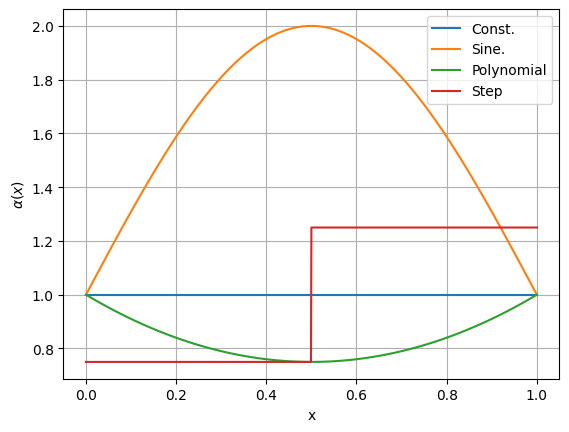

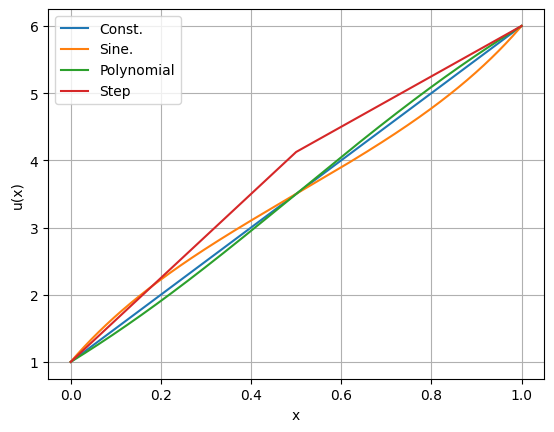

In [141]:
N = 1000
x = np.linspace(0,1, N+1)


rhs = np.zeros(N+1) # LaPlace
# rhs = np.ones(N+1) * 1 # Poission

# choose alpha(x). Ensure that given dirichlet BCs are satisfied (alpha(x=0) = alpha(x=1) = 1)
alpha_1 = np.ones(N+1) # constant
alpha_2 = 1 + np.sin(np.pi*x) #sine
alpha_3 = 1 + x*(x-1) #polynomial
alpha_4 = np.copy(alpha_1)
alpha_4[x < 0.5] = 0.75
alpha_4[x >= 0.5] = 1.25
pass # OPTIONAL: try more alpha(x)


u1 = solve_poisson(alpha_1, rhs, U0, U1)
u2 = solve_poisson(alpha_2, rhs, U0, U1)
u3 = solve_poisson(alpha_3, rhs, U0, U1)
u4 = solve_poisson(alpha_4, rhs, U0, U1)

plt.figure()
plt.plot(x, alpha_1, label = 'Const.')
plt.plot(x, alpha_2, label = 'Sine.')
plt.plot(x, alpha_3, label = 'Polynomial')
plt.plot(x, alpha_4, label = 'Step')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel(r'$\alpha(x)$')

plt.figure()
plt.plot(x, u1, label = 'Const.')
plt.plot(x, u2, label = 'Sine.')
plt.plot(x, u3, label = 'Polynomial')
plt.plot(x, u4, label = 'Step')
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('u(x)')

[-2.56003264e+01 -1.28001632e+02 -6.40008159e+02 -3.20004079e+03
 -1.60002040e+04 -8.00010199e+04 -4.00005099e+05 -2.00002550e+06]


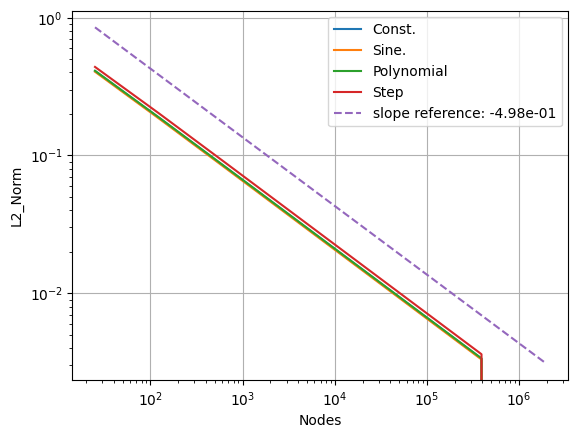

In [142]:
N_list = np.array([5**x for x in range(2,10)])

def get_L2Norm(vals):

    return np.sqrt(np.sum(vals**2))/vals.size

u1_N,u2_N,u3_N,u4_N = [],[],[],[]

for N in N_list:
    
    x = np.linspace(0,1, N+1)


    rhs = np.zeros(N+1) # LaPlace
    # rhs = np.ones(N+1) * 1 # Poission

    # choose alpha(x). Ensure that given dirichlet BCs are satisfied (alpha(x=0) = alpha(x=1) = 1)
    alpha_1 = np.ones(N+1) # constant
    alpha_2 = 1 + np.sin(np.pi*x) #sine
    alpha_3 = 1 + x*(x-1) #polynomial
    alpha_4 = np.copy(alpha_1)
    alpha_4[x < 0.5] = 0.75
    alpha_4[x >= 0.5] = 1.25
    pass # OPTIONAL: try more alpha(x)


    u1_N.append(get_L2Norm(solve_poisson(alpha_1, rhs, U0, U1)))
    u2_N.append(get_L2Norm(solve_poisson(alpha_2, rhs, U0, U1)))
    u3_N.append(get_L2Norm(solve_poisson(alpha_3, rhs, U0, U1)))
    u4_N.append(get_L2Norm(solve_poisson(alpha_4, rhs, U0, U1)))


plt.figure()
plt.loglog(N_list, np.abs(np.hstack((np.diff(u1_N),0))), label = 'Const.')
plt.loglog(N_list, np.abs(np.hstack((np.diff(u2_N),0))), label = 'Sine.')
plt.loglog(N_list, np.abs(np.hstack((np.diff(u3_N),0))), label = 'Polynomial')
plt.loglog(N_list, np.abs(np.hstack((np.diff(u4_N),0))), label = 'Step')

plt.grid()
plt.xlabel('Nodes')
plt.ylabel('L2_Norm')

res = stats.linregress(np.log10(N_list[:-1]), np.log10(np.abs(np.hstack((np.diff(u1_N))))))
# print(res)
print((res.slope*N_list) * 10.**res.intercept)
plt.loglog(N_list, 10**(res.slope*np.log10(N_list)) * 100.**res.intercept, '--', label = f'slope reference: {res.slope:.2e}')

plt.legend()


## 2. Bayesian modelling

Now consider the inverse problem of determining an unknown $\alpha(x)$, given *observations* $d$ of $u(x)$.  We use Bayesian methodology - as discussed in the lectures.  The Bayesian framework answers the question: "*What is probability of a dissipation coefficient $\boldsymbol{\alpha}$ given the observations $d$?*", with $\rho(\alpha\mid d)$.  

We want to apply the framework to the *discretized* system of the previous section.  However if we use $\alpha$ defined at every grid-point as our parameters, then we'll have $100$ parameters, which is too high-dimensional for now (we'll address this in Tutorial 5!)  Instead we'll represent $\alpha(x)$ with a cubic-spline, and use the values at the interior spline-nodes $\theta_i$, $i \in \{1,\dots,M\}$ as our parameters.  This will let us play with $M$, the number of parameters.  The outer two nodes will be fixed at $1$ to enforce the condition $\alpha(0)=\alpha(1)=1$.  We'll enforce a minimum on the result, to prevent negative $\alpha$ anywhere:
$$
\alpha(x) \simeq \max( S_M[\theta](x), \alpha_\mathrm{min} ),
$$
where $S_M$ is a cubic spline with $(M+2)$-nodes, taking the values $(1, \theta_1, \dots, \theta_M, 1)$ at the nodes.  The function `alpha_spline()` below implements exactly this.  Again play a little to check you understand what is happening.  [Note: The number of nodes is determined by the size of `theta`].

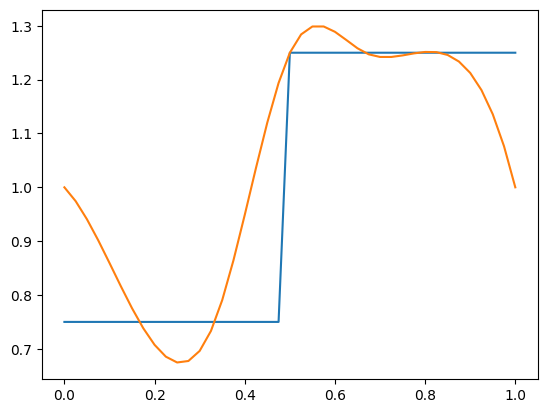

In [143]:
from scipy.interpolate import CubicSpline
def alpha_spline(xx, theta):
    """
    Cubic-spline in 1d taking values theta at uniformly spaced nodes on [0,1].
    
    Args:
        xx (ndarray): Locations at which to evaluate spline.
        theta (ndarray): Values of spline at interior nodes (to interpolate). Dimension M.
    Return:
        s (ndarray): Value of spline at locations xx.  Same shape as xx.
    """
    M = theta.shape[0]
    thetamod = np.ones(M+2); thetamod[1:-1] = theta  # Extend theta with endpoints
    alpha_min = 0.01  # Lower cut-off for alpha
    xnodes = np.linspace(0,1,M+2)  # Nodes of spline
    return np.clip( CubicSpline(xnodes, thetamod)(xx), alpha_min, None )

N_spline = 40
xx = np.linspace(0,1, N_spline+1)
alpha_4 = np.ones(N_spline+1)
alpha_4[xx < 0.5] = 0.75
alpha_4[xx >= 0.5] = 1.25
alpha_test = alpha_4
alpha_test_spline = alpha_spline(xx,alpha_test[::10])

plt.plot(xx,alpha_test)
plt.plot(xx,alpha_test_spline)

Then the posterior distribution of $\boldsymbol{\theta}$ given $d$ is (by Bayes' rule):
$$
\rho(\boldsymbol{\theta} | d) \propto \rho(d | \boldsymbol{\theta}) \cdot \rho_0(\boldsymbol{\theta}).
$$
It remains to define the likelihood $\rho(d | \boldsymbol{\theta})$ and the prior $\rho_0(\boldsymbol{\theta})$.

### Prior

The unknown $\alpha(x)$ is positive, so $\theta_i$ should be positive.  Otherwise we don't know much *a priori*.  Since we're planning to use McMC we don't need to worry about finding a *conjugate prior*, so we can choose any distribution for the $\theta_i$.  See "Continuous distributions" at https://docs.scipy.org/doc/scipy/reference/stats.html for some options.  

**EXERCISE 2.1**

Choose $\theta_i$ independent identically distributed (i.i.d.) log-normal with mean $1$:
$$
\theta_i \sim \log\mathcal{N}(1), \quad \mathrm{i.i.d.} \quad \forall i\in{1,...,M}
$$

Complete the implementation of the following two functions.  It's handy to use `scipy.stats.lognorm()`, which has the methods `logpdf()` and `rvs()` as do all the distributions in `scipy.stats`.  (Note: In many instances we prefer to work with the log-pdf than the pdf for reasons of numerical accuracy, especially when probabilities involved become very small.)

In [144]:
from scipy.stats import lognorm

def prior_logpdf(theta):
    """
    Return the log-pdf of theta = (theta_1, ... \theta_M), where each theta_i is
    i.i.d. log-normal with mean 1.
    
    Args:
      theta (array): 
    """
    sigma = 0.5
    mu = 1
    
    
    logpdf_values = lognorm.logpdf(theta, s=sigma, scale=np.exp(mu))
    return np.sum(logpdf_values)

def prior_samples(M):
    """
    Return sample of theta = (theta_1, ... \theta_M), where each theta_i is
    i.i.d. log-normal with mean 1.
    
    Args:
        M (int): Size of theta.
    """
    sigma = 0.5
    mu = 1
    
    # Using scipy's lognorm to generate samples
    samples = lognorm.rvs(s=sigma, scale=np.exp(mu), size=M)
    return samples


**EXERCISE 2.2**

Generate some samples from the prior on $\theta$ and thereby the implied prior on $\alpha$ (using the spline).  Plot 10 samples of $\alpha$, using $M=10$.  Again the objective here is to get an impression of the kind of functions that are likely under the prior.

Text(0, 0.5, '$\\alpha$')

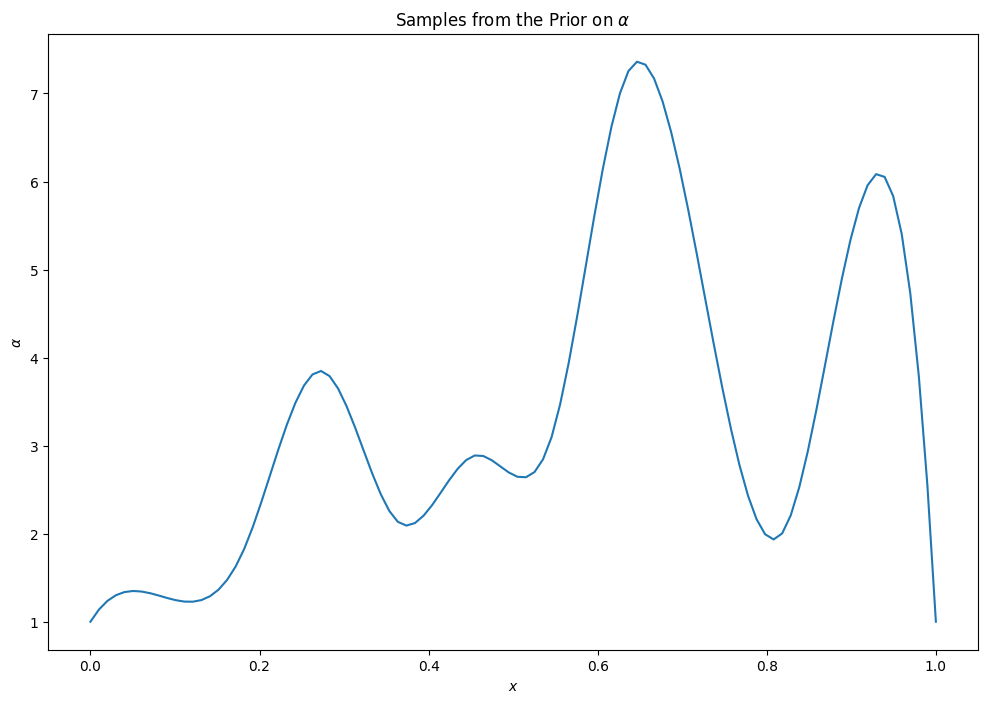

In [145]:
M = 10
num_samples = 1
xx = np.linspace(0, 1, 100)  # Locations at which to evaluate the spline

plt.figure(figsize=(12, 8))

for _ in range(num_samples):
    theta = prior_samples(M)
    alpha = alpha_spline(xx, theta)
    plt.plot(xx, alpha)

plt.title('Samples from the Prior on $\\alpha$')
plt.xlabel('$x$')
plt.ylabel('$\\alpha$')


### Likelihood

An expression for $\rho(d | \boldsymbol{\theta})$ is obtained from a statistical model.  Here we use the model:
$$
d_j = u(x^d_j; \alpha(\theta)) + \epsilon_j,\quad \epsilon_j \sim \mathcal{N}(0, \sigma_d^2),\quad j\in\{1,\dots,M\}
$$
where the *observation noise* in observation $d_j$ is $\epsilon_j$, which is modelled as unbiased Gaussian noise with standard-deviation $\sigma_d$, and $x^d_j \in [0,1]$ is the location of the $j$-th observation (not necessarily a grid node).  We have explicitly indicated the dependence of $u$ on $\alpha$; and in turn $\alpha$'s dependence on $\theta$.

In discrete form:
$$
d = H \hat u(\hat\alpha(\theta))  + \boldsymbol{\epsilon},\quad \boldsymbol{\epsilon}\sim\mathcal{N}(0,R)
$$
where $H: \mathbb{R}^N\rightarrow\mathbb{R}^M$ is the observation operator that extracts an approximation of $u(x^d_j)$ from the discrete solution $\hat u$.  Here we use piecewise-linear interpolation - using `numpy.interp()` - which is a linear operation, i.e. $H$ is a matrix as usual.  By rearranging
$$
d - H \hat u \sim \mathcal{N}(0,R)
$$
so the resulting expression for the likelihood is
$$
\rho(d | \boldsymbol{\theta}) = \rho_\epsilon\left(d - H \hat u \right) \propto \exp\left\{-\frac{1}{2}(d - H \hat u(\theta))^T R^{-1}(d - H \hat u(\theta))\right\},
$$
where throughout $\hat u$ is assumed to always satisfy the discrete problem exactly, i.e. $\mathcal{R}(\hat u;\hat{\alpha}) = 0$. [Throughout, we are using the fact that we can write $\hat u$ as a function of $\theta$ (via $\alpha$), i.e. $\hat u := \hat u(\hat\alpha(\theta)) =: \hat u(\theta)$, dropping $\alpha$ by notational convenience.]

**EXERCISE 2.3**

Implement the above likelihood in `likelihood_logpdf()` below.  Each call must invoke three operators, mapping successively $\theta \rightarrow \hat\alpha \rightarrow \hat u \rightarrow H\hat u$.  This is the model's prediction of the data, which is then to be compared with the provided data $d$.  Don't worry about correct normalization of the likelihood, as we will use McMC the constant of proportionality can be ignored.

In [146]:
def likelihood_logpdf(N, theta, xd, d):
    """
    Compute the log-likelihood for the inverse Poisson problem.
    
    Args:
       N (int): Number of grid points
       theta (array): Size M, parameters of spline
       xd (array): Size P, locations of observations
       d (array): Size P, values of observations of u
    """
    raise NotImplementedError   # TODO

sigma_d = 1e-2
def likelihood_logpdf(N, theta, xd, d):
    """
    Compute the log-likelihood for the inverse Poisson problem.
    
    Args:
       N (int): Number of grid points
       theta (array): Size M, parameters of spline
       xd (array): Size P, locations of observations
       d (array): Size P, values of observations of u
    """
    
    x_grid = np.linspace(0, 1, N+1)
    alpha = alpha_spline(x_grid, theta)
    

    u = solve_poisson(alpha, rhs = np.zeros(N+1), U0 = 1, U1 = 6)
    
    
    u_at_xd = np.interp(xd, x_grid, u)
    
    
    R_inv = np.eye(len(d)) / (sigma_d ** 2) 
    e = d - u_at_xd
    log_likelihood = -0.5 * e.T @ R_inv @ e
    
    return log_likelihood

**EXERCISE 2.4**

We now verify your implementation by means of a *twin-problem* in the following steps (already implemented below): 

1. Choose a particular $\theta_\mathrm{truth}$ (arbetraily).
1. Generate `alpha_truth` with solution `u_truth` using $\theta_\mathrm{truth}$.
1. Get "data" `d` by sampling `u_truth` at a few observation locations `xd`.
1. Now build your objective function with a standard grid `xx`, and evaluate the posterior for some new $\theta$.

Now your posterior *should* be maximum where $\theta = \theta_\mathrm{truth}$.  For convenience of plotting we use only 2d $\theta$ for now - so the spline has 4 nodes (including the end nodes).

Then we can plot the posterior probability as a function of $\theta_1$ and $\theta_2$.  The following code does this.   Run it, and verify that your posterior is reasonable according to your expectations.  In particular: Is the true $\theta$ likely under the posterior?  Are $\theta$s that result in significantly different $u$s *unlikely*?

Text(0, 0.5, '$\\theta_2$')

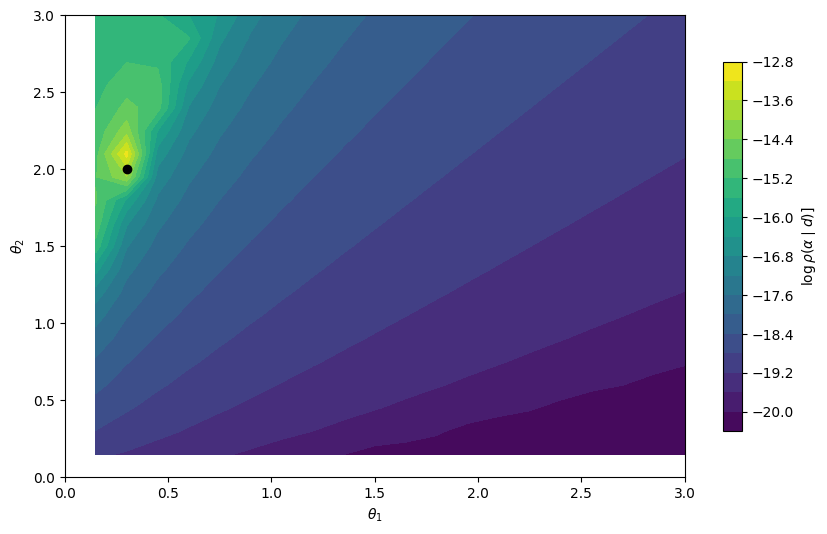

In [147]:
theta_truth = np.array([0.3,2.0])

# Observation locations and simulation grid respectively
N = 200  # Number of grid-points
P = 100   # Number of observations
xd = np.linspace(0,1,P)
xx = np.linspace(0,1,N)
alpha_truth = alpha_spline(xx, theta_truth)
# alpha_truth = (xx < 0.3)+0.1  ### Challenge: Uncomment for EXERCISE 3.5

# Reference solution sampled at the observation points
# This defines our reference for alpha with amplitude=0.55, frequency=5.
u_truth = solve_poisson(alpha_truth, 0., U0, U1)
d = np.interp(xd, xx, u_truth, left=U0, right=U1)
sigma_d = 0.001

# Posterior 
def posterior_logpdf(theta):
    return likelihood_logpdf(N, theta, xd, d) + prior_logpdf(theta)

# Plotting code
theta1 = np.linspace(0.,3, 21)
theta2 = np.linspace(0.,3, 21)
Theta1,Theta2 = np.meshgrid(theta1, theta2)
Pdf = np.zeros(Theta1.shape)
for i in range(21):
    for j in range(21):
        # Evaluate the posterior for each theta
        Pdf[i,j] = posterior_logpdf(np.array([Theta1[i,j], Theta2[i,j]]))
plt.figure(figsize=(10,6))
CS = plt.contourf(Theta1, Theta2, -np.log(-Pdf), 21)
plt.plot(theta_truth[0], theta_truth[1], 'ok')  # True solution
cbar = plt.colorbar(CS, shrink=0.8, extend='both')
cbar.ax.set_ylabel(r'$\log\rho(\alpha\mid d)]$')
plt.xlabel(r'$\theta_1$'); plt.ylabel(r'$\theta_2$')


## 3. Markov-Chain Monte-Carlo

So with two parameters, direct inspection of the posterior is possible - but we can't represent very general functions with just two parameters.  To extract information from higher-dimensional posteriors we need McMC.  In outline the algorithm is as follows:

1. Select an initial guess `theta0`.
2. Evaluate the posterior at `theta0`, with `posterior_logpdf(theta0)`.
3. Iterate from 1 until `Nsamples`
   - Select a sample `theta_p` from the propsal distribution `G`
   - Compute the posterior log-pdf at `theta_p`
   - Accept or reject `theta_p` using the criteria from the lectures
   - If accept add `theta_p` to the end of the chain; if reject repeat the last entry in the chain.

**EXERCISE 3.1**  Implement Metropolis-Hastings McMC.

Hints:
- For `G` use $G \sim \mathcal{N}(\theta^{(i)}, \sigma_p^2 I)$, where $\theta^{(i)}$ is the last state added to the chain.  Use `G = scipy.stats.multivariate_normal(...)`, and sample with `G.rvs()`.  
- To generate a uniform sample from $[0,1]$ use `scipy.stats.uniform(0,1).rvs()`.
- Remember to convert from log-pdfs to pdfs to do the accept/reject check.
- It's handy to report the *acceptance ratio* - i.e. number of accepted, divided by total samples.

In [148]:
# def mcmc(M, logpdf, theta0, Nsamples, sigma_p):
#     """
#     Perform McMC (Metropolis-Hastings) for the given log-pdf.  Return the
#     resulting Markov-chain.

#     Args:
#       M (int): Dimension of parameter vector.
#       logpdf (function): Takes theta (array of length M), returns log-pdf.
#       theta0 (array): Initial guess of theta, length M.
#       Nsamples (int): Total number of samples to compute.
#       sigma_p (float): Standard-deviation of the proposal distribution.
    
#     Return:
#       chain (array): Shape (Nsamples, M), the resulting Markov-Chain.
#     """
#     raise NotImplementedError   # TODO

In [149]:
def mcmc(M, pdf, theta0, N, sigma_prop):

    chain = np.zeros((N, M))
    pdfs = np.zeros(N)
    accepts = np.zeros(N, dtype=bool)
    
    # Init chain
    chain[0, :] = theta0
    pdfs[0] = pdf(theta0)
    accepts[0] = True
    

    Y = stats.uniform(0, 1)
    
    # Iterate
    for i in range(1, N):
        # sample from proposal distribution centered at the last sample
        G = stats.multivariate_normal(chain[i-1], np.eye(M) * sigma_prop**2)
        theta_proposed = G.rvs()
        pdf_proposed = pdf(theta_proposed)
        
        
        y = Y.rvs()
        
        # Acceptance criterion
        acceptance_ratio = np.exp(pdf_proposed - pdfs[i-1])  # Convert log-pdf to pdf ratio
        if y < acceptance_ratio:  # ACCEPT
            chain[i] = theta_proposed
            pdfs[i] = pdf_proposed
            accepts[i] = True
        else:  # REJECT
            chain[i] = chain[i-1]
            pdfs[i] = pdfs[i-1]
            accepts[i] = False
    
    
    acceptance_ratio = np.sum(accepts) / N
    print(f'Acceptance ratio = {acceptance_ratio * 100:.2f}%')
    
    return chain

**EXERCISE 3.2**

Verify your implementation against a simple distribution.  The following code checks that your `mcmc()` samples correctly from a normal distribution.  It plots a histogram of your chain, and compares with the exact pdf.  These should agree increasingly well as the number of samples increases.  If not something is wrong.  For this case `sigma_p=1` is close to optimal, and `Nsamples=1000` will produce a fairly good match, with acceptance ratio close to 70%.  Experiment with varying both these parameters.  You can also replace `norm_pdf()` with any other pdf, and the match with the histogram should still work.  The goal here is primarily to verify your implementation and get a feeling for the roles of the parameters.

Acceptance ratio = 70.80%


Text(0, 0.5, 'Density')

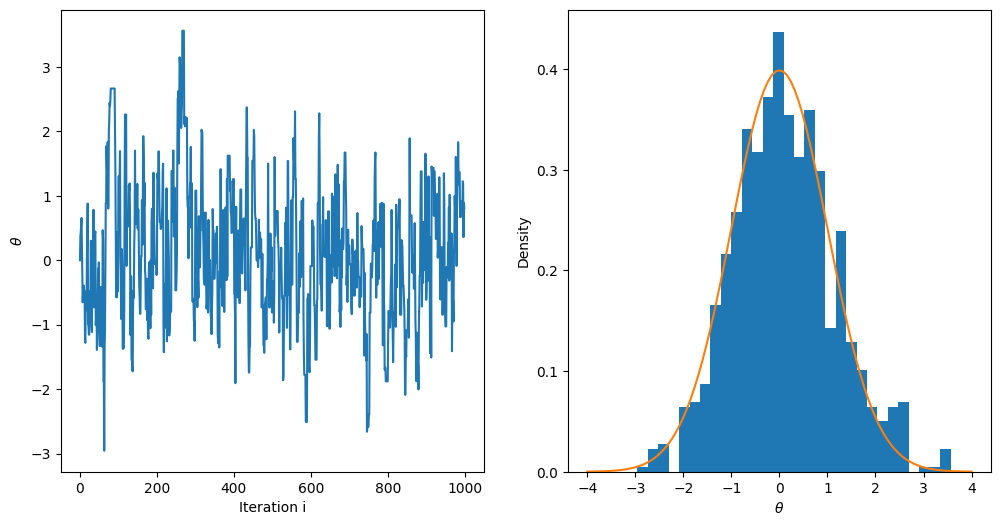

In [150]:
def norm_pdf(x): return np.exp(-.5*x**2) / np.sqrt(2*np.pi)
def norm_logpdf(x): return np.log(norm_pdf(x))

Nsamples = 1000
chain = mcmc(1, norm_logpdf, np.array([0]), Nsamples, 1.0)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(chain)
plt.xlabel('Iteration i'); plt.ylabel(r'$\theta$')
plt.subplot(122)
plt.hist(chain, density=True, bins=30)
x1 = np.linspace(-4,4,101)
plt.plot(x1, norm_pdf(x1), '-')
plt.xlabel(r'$\theta$'); plt.ylabel('Density')


**EXERCISE 3.3**

Verify your implementation in the two-dimensional case.  Again, for a correctly implemented `mcmc()` you should be able to run the code below, and see the agreement of the pdf with your samples.  In particular the shape of the pdf (visible as contours in the left plot), should agree with the plotted samples (in the same plot), and the shape of the histogram (in the right plot).  If not, something is wrong with `mcmc()`.  Again it may be instructive to look at the influence of proposal distribution.

Acceptance ratio = 51.70%


Text(0, 0.5, '$\\theta_2$')

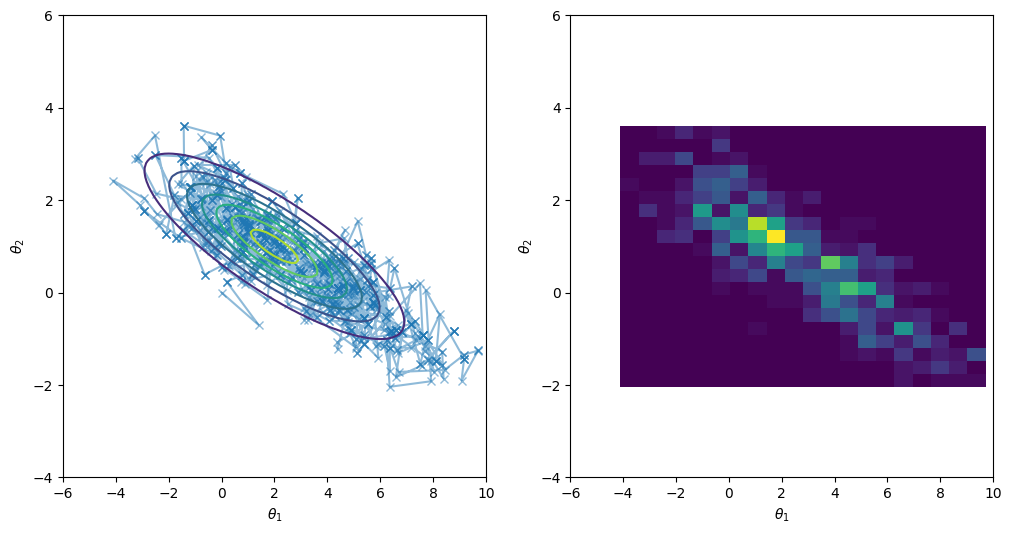

In [151]:
def norm_logpdf(x):
    mu = np.array([2,1])
    P = np.array([[6,-2],[-2,1]])
    return stats.multivariate_normal(mu, P).logpdf(x)

theta0 = np.array([0,0])
Nsamples = 1000
chain = mcmc(2, norm_logpdf, theta0, Nsamples, 1)

# Plot the chain
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(chain[:,0], chain[:,1], '-x', alpha=0.5)

# Plot the PDF
x1, y1 = np.linspace(-6, 10, 101), np.linspace(-4, 6, 101)
XX, YY = np.meshgrid(x1, y1)
ZZ = np.exp(norm_logpdf(np.stack((XX[:,:], YY[:,:]), axis=-1) ))
plt.contour(XX, YY, ZZ, zorder=999)
plt.xlim(-6, 10); plt.ylim(-4, 6)
plt.xlabel(r'$\theta_1$'); plt.ylabel(r'$\theta_2$')

# Plot a histogram
plt.subplot(122)
plt.hist2d(chain[:,0], chain[:,1], bins=20, density=True)
plt.xlim(-6, 10); plt.ylim(-4, 6)
plt.xlabel(r'$\theta_1$'); plt.ylabel(r'$\theta_2$')

**EXERCISE 3.4**

We are finally ready to apply MCMC to the inverse Poisson problem.  First consider the 2d case for which we already visualized the contours of the posterior.  The `d`, `alpha_truth`, as well as `posterior_logpdf()` etc. are defined there, so rerun that cell if they are not initialized.

Apply McMC - this may take a while as `Nsample` Poisson solves must be computed.  If your acceptance ratio is too low (< 1%) reduce your `sigma_p`.  If it gets too high (>90%) increase `sigma_p`.  Note how the ideal `sigma_p` is a function of the size of the posterior.  Hence the need for adaptive versions of McMC that can adjust this parameter automatically.

---

sigma_p needs to be kept really low (0.0002, compared to 1.0 previously) to ensure a relatively high acceptance rate

C:\Users\ndigh\AppData\Local\Temp\ipykernel_10092\198262062.py:26: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(pdf_proposed - pdfs[i-1])  # Convert log-pdf to pdf ratio


Acceptance ratio = 31.32%


Text(0, 0.5, '$\\theta_2$')

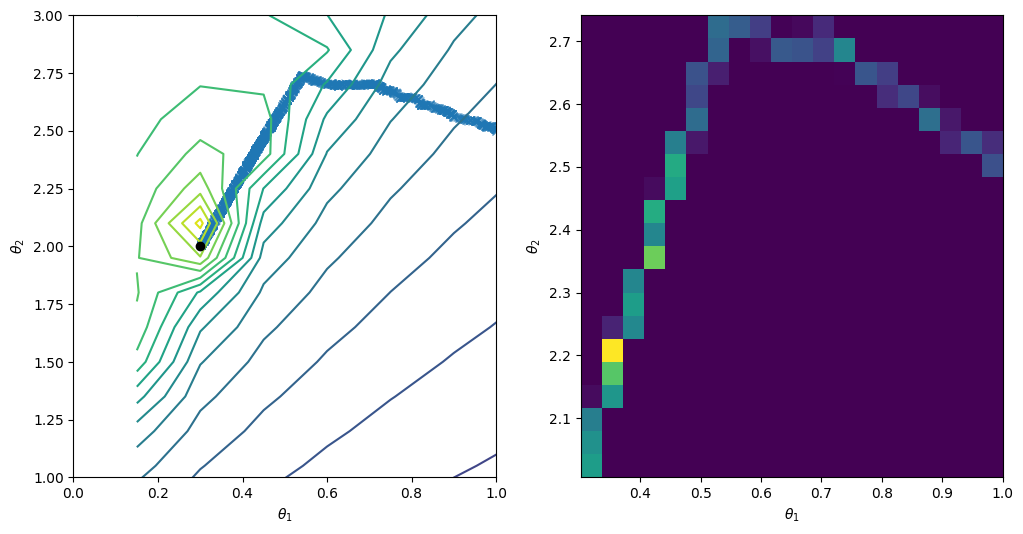

In [152]:
N_samples = 2500
chain = mcmc(M = 2, pdf = posterior_logpdf, theta0 = np.array([1,2.5]), N = N_samples, sigma_prop = 0.002)

# Plot the chain
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(chain[:,0], chain[:,1], '-x', alpha=0.5)

# Plot the PDF
CS = plt.contour(Theta1, Theta2, -np.log(-Pdf), 21)
plt.plot(theta_truth[0], theta_truth[1], 'ok')  # True solution
plt.xlabel(r'$\theta_1$'); plt.ylabel(r'$\theta_2$')
plt.xlim(0, 1); plt.ylim(1, 3)

# Plot a histogram
plt.subplot(122)
plt.hist2d(chain[:,0], chain[:,1], bins=20, density=True)
plt.xlabel(r'$\theta_1$'); plt.ylabel(r'$\theta_2$')

Now visualize the chain by plotting it.  You can plot each $\theta_i$ against the iterations, resulting in $M$ so-called *traces*.  You can also plot $\theta_i$ against $\theta_j$ to see the random-walk - in two of its dimensions at least.  Verify that the chain generally moves toward regions of high-posterior probability.  Ideally the traces should appear *statistically stationary* after perhaps a few thousand iterations, i.e. that they are no longer trending up or down, but just osciallating randomly.

Text(0, 0.5, '$\\theta_2$')

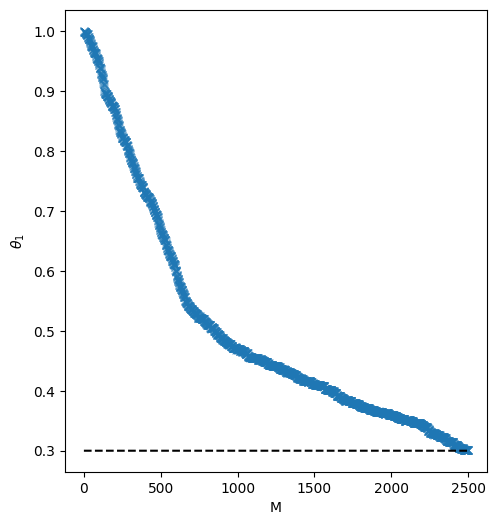

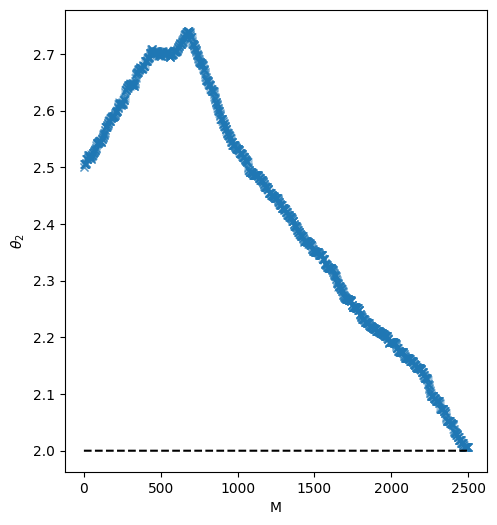

In [153]:
# plot theta1 against N
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(np.arange(1, N_samples+1), chain[:,0], '-x', alpha=0.5)
plt.plot(np.arange(1, N_samples+1), np.ones(N_samples)*theta_truth[0], '--', color = 'black')  # True solution
plt.xlabel(r'M'); plt.ylabel(r'$\theta_1$')

# plot theta2 against N
plt.figure(figsize=(12,6))
plt.subplot(122)
plt.plot(np.arange(1, N_samples+1), chain[:,1], '-x', alpha=0.5)
plt.plot(np.arange(1, N_samples+1), np.ones(N_samples)*theta_truth[1], '--', color = 'black')  # True solution
plt.xlabel(r'M'); plt.ylabel(r'$\theta_2$')

Another way of visualizing the chain, is by visualizing the functions $\alpha$ and $u$ that result from samples in the chain $\theta^{(i)}$.  Plot 100 samples of $\alpha$ and $u$ against $x$ (on separate axes), and compare them with the true functions `u_truth` and `alpha_truth`.  Take every 10th sample from the *end* of the chain for this purpose (why?).  Verify that the corresponding $\alpha$ and $u$ agree with the truth.

---
Solution should be the most accurate at the end of the Markov chain. Also, every 10th sample reduces the number of poisson solves

on solves


Loop1
Acceptance ratio = 40.00%

Loop2
Acceptance ratio = 40.00%

Loop3
Acceptance ratio = 43.33%

Loop4
Acceptance ratio = 55.00%

Loop5
Acceptance ratio = 52.00%

Loop6


C:\Users\ndigh\AppData\Local\Temp\ipykernel_10092\198262062.py:26: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(pdf_proposed - pdfs[i-1])  # Convert log-pdf to pdf ratio


Acceptance ratio = 53.33%

Loop7
Acceptance ratio = 42.86%

Loop8
Acceptance ratio = 47.50%

Loop9
Acceptance ratio = 47.78%

Loop10
Acceptance ratio = 58.00%

Loop11
Acceptance ratio = 49.09%

Loop12
Acceptance ratio = 53.33%

Loop13
Acceptance ratio = 48.46%

Loop14
Acceptance ratio = 51.43%

Loop15
Acceptance ratio = 57.33%

Loop16
Acceptance ratio = 41.25%

Loop17
Acceptance ratio = 48.82%

Loop18
Acceptance ratio = 52.22%

Loop19
Acceptance ratio = 50.00%

Loop20
Acceptance ratio = 49.00%

Loop21
Acceptance ratio = 45.24%

Loop22
Acceptance ratio = 49.09%

Loop23
Acceptance ratio = 53.91%

Loop24
Acceptance ratio = 47.92%

Loop25
Acceptance ratio = 46.80%

Loop26
Acceptance ratio = 47.69%

Loop27
Acceptance ratio = 50.74%

Loop28
Acceptance ratio = 50.00%

Loop29
Acceptance ratio = 51.03%

Loop30
Acceptance ratio = 55.00%

Loop31
Acceptance ratio = 55.16%

Loop32
Acceptance ratio = 50.62%

Loop33
Acceptance ratio = 55.15%

Loop34
Acceptance ratio = 51.76%

Loop35
Acceptance ratio 

Text(0, 0.5, 'u')

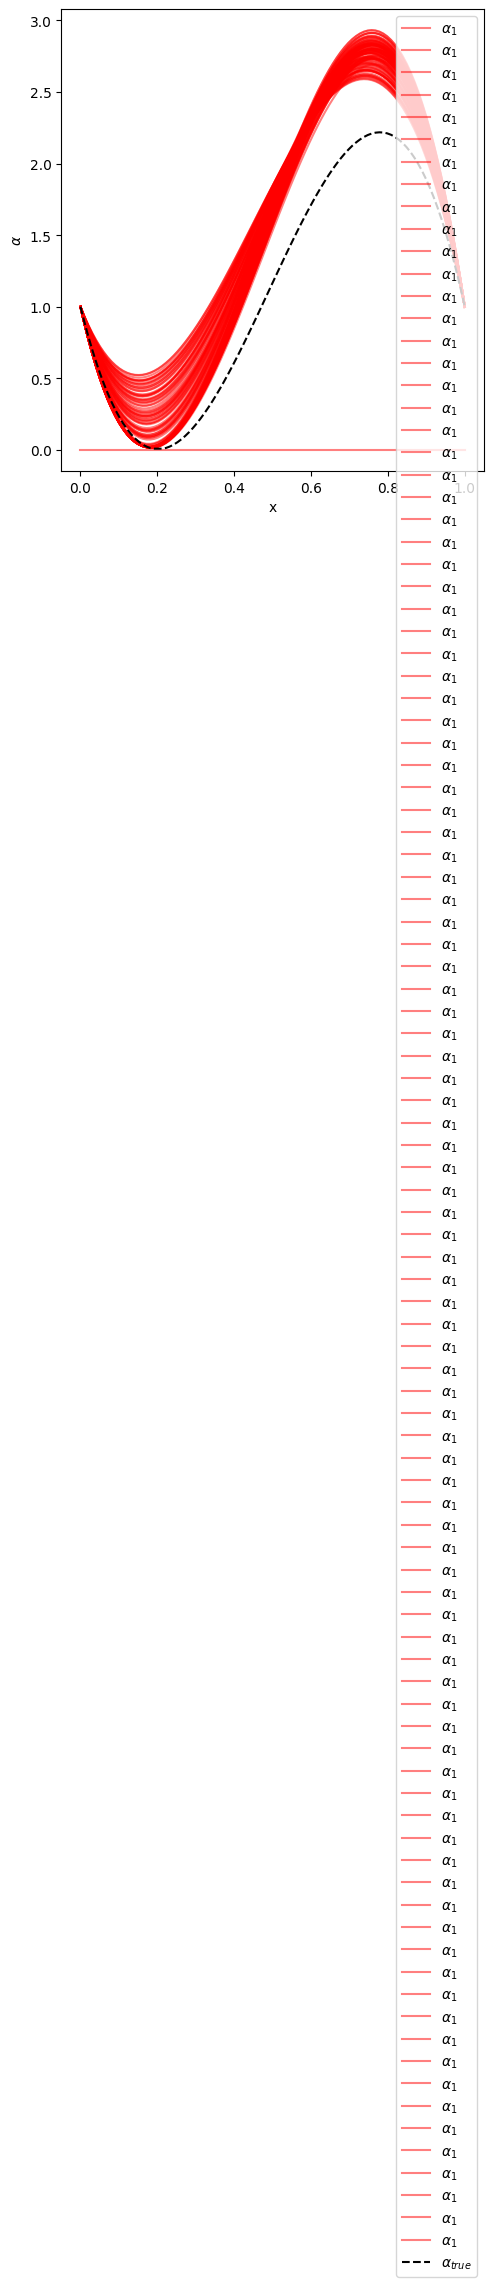

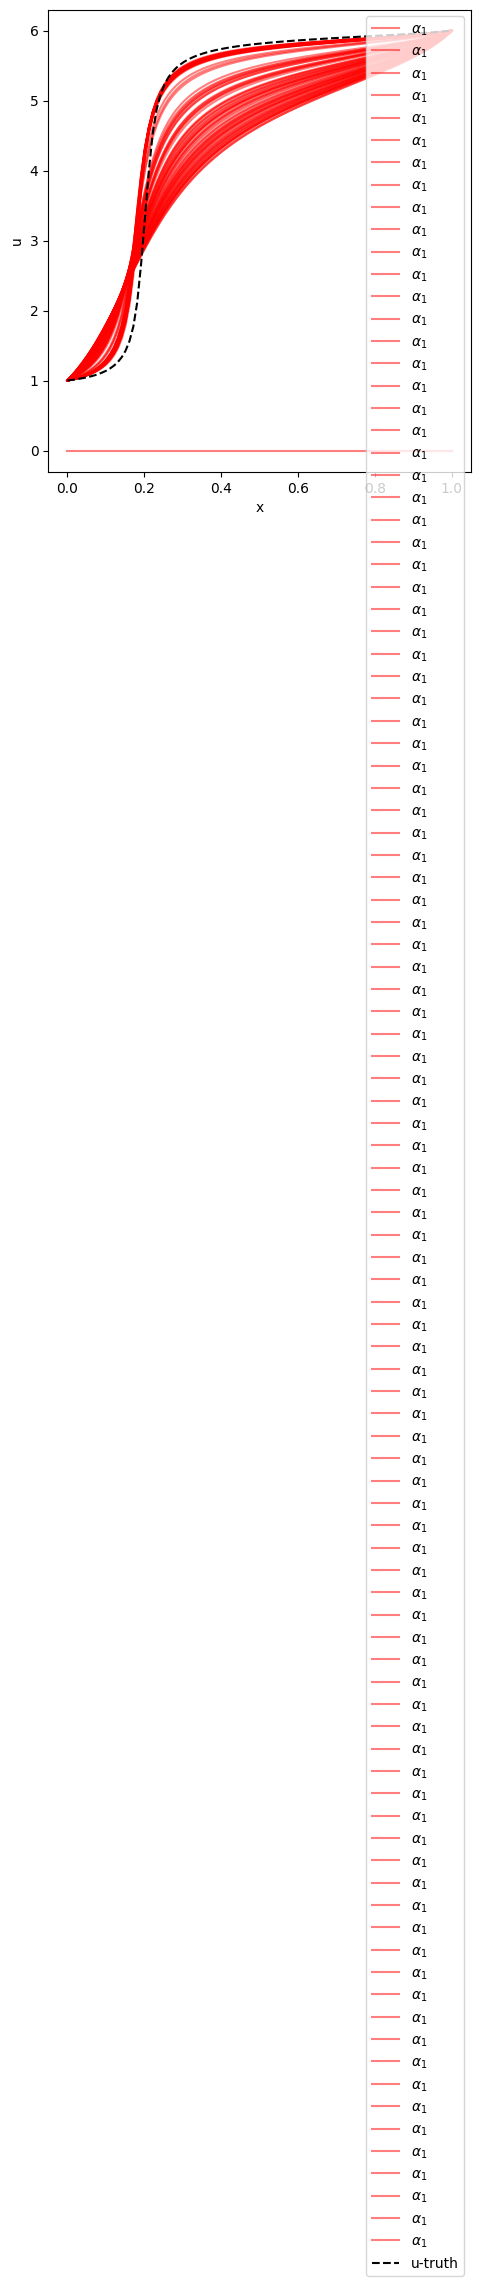

In [156]:
P = 100 # number of samples for plotting
M = 2 # 1D only
pitch = 10 # sampling rate
N_tot = P*pitch # total number of runs
xd = np.linspace(0,1,P)

alpha = np.zeros((len(xd), P))
u = np.zeros((len(xd), P))
theta = np.zeros((M,P))

for i in range(1, P):
    print(f'\nLoop{i}')
    chain = mcmc(M, pdf = posterior_logpdf, theta0 = np.array([1,2.5]), N = i*pitch, sigma_prop = 0.002)
    theta[0, i] = chain[-1, 0]
    theta[1, i] = chain[-1, 1]
    alpha[:, i] = alpha_spline(xd,theta[:,i])
    u[:, i] = solve_poisson(alpha[:,i], 0., U0, U1)


# alpha = alpha_spline(xd,theta)
# u = solve_poisson(alpha, 0., U0, U1)


# pitch = int(N_samples/P)

# theta1 = chain[:,0]
# theta2 = chain[:,1]

# alpha1 = alpha_spline(xd, theta1[::pitch])
# u1 = solve_poisson(alpha1, 0., U0, U1)

# alpha2 = alpha_spline(xd, theta2[::pitch])
# u2 = solve_poisson(alpha2, 0., U0, U1)



theta_truth = np.array([0.3,2.0])
N = 100  # Number of grid-points
xx = np.linspace(0,1,N)
alpha_truth = alpha_spline(xx, theta_truth)
u_truth = solve_poisson(alpha_truth, 0., U0, U1)


# plot alpha against x
plt.figure(figsize=(12,6))
plt.subplot(121)
for i in range(P):
    plt.plot(xd, alpha[:,i], color = 'red', alpha=0.5)
plt.plot(xx, alpha_truth,  '--', color = 'black', label = r'$\alpha_{true}$')  # True solution
plt.legend()
plt.xlabel(r'x'); plt.ylabel(r'$\alpha$')

# plot theta against M
plt.figure(figsize=(12,6))
plt.subplot(122)
for i in range(P):
    plt.plot(xd, u[:,i], color = 'blue', alpha=0.5)
plt.plot(xx, u_truth,  '--', color = 'black', label = 'u-truth')  # True solution
plt.legend()
plt.xlabel(r'x'); plt.ylabel('u')


**EXERCISE 3.5**

As a final test, uncomment `alpha_truth = (xx < 0.3)+0.1` in the twin-problem cell above (in EXERCISE 2.4).  Rerun that cell to generate new test data.  Rerun your McMC sampling and visualization for this new truth.  The goal is to infer the form of $\alpha$ from only the observations of $u$.  Since $\alpha$ is discontinuous, $M=2$ will definitely not be sufficient to recreate it, so increase $M$ until a good (eyeball norm) match with $u$ is obtained in the plots of EXERCISE 3.4.

It's fine to just rerun the cells of EXERCISE 3.4 to generate these plots.  I don't need to see the plots for the original EXERCISE 3.4 in the submitted notebook.

Do you need to modify `sigma_p` significantly when increasing $M$?  Does you acceptance ratio rise or fall as dimension increases?  Does your *burn-in* period get longer or shorter?  (Burn-in is the first part of the chain that is influenced by the initial guess, before statistical stationarity.)  Does your prediction of $\alpha$ agree with the truth?

In [ ]:
# previous cells left commented, to avoid unexpected overwriting of variables. Relevant information is statically copied here:
P = 40   # Number of observations
xd = np.linspace(0,1,P)
alpha_truth = (xx < 0.3)+0.1  ### Challenge: Uncomment for EXERCISE 3.5
u_truth = solve_poisson(alpha_truth, 0., U0, U1)
d = np.interp(xd, xx, u_truth, left=U0, right=U1)
sigma_d = 0.001

In [ ]:
N_samples = 2500
chain = mcmc(M = 2, pdf = posterior_logpdf, theta0 = np.array([1,2.5]), N = N_samples, sigma_prop = 0.002)

# Plot the chain
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(chain[:,0], chain[:,1], '-x', alpha=0.5)

# Plot the PDF
CS = plt.contour(Theta1, Theta2, -np.log(-Pdf), 21)
plt.plot(theta_truth[0], theta_truth[1], 'ok')  # True solution
plt.xlabel(r'$\theta_1$'); plt.ylabel(r'$\theta_2$')
plt.xlim(0, 1); plt.ylim(1, 3)

# Plot a histogram
plt.subplot(122)
plt.hist2d(chain[:,0], chain[:,1], bins=20, density=True)
plt.xlabel(r'$\theta_1$'); plt.ylabel(r'$\theta_2$')



# plot alpha against x
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(xd, alpha1, color = 'red', alpha=0.5, label = r'$\alpha_1$')
plt.plot(xd, alpha2, color = 'blue', alpha=0.5, label = r'$\alpha_2$')
plt.plot(xx, alpha_truth,  '--', color = 'black', label = r'$\alpha_{true}$')  # True solution
plt.legend()
plt.xlabel(r'x'); plt.ylabel(r'$\alpha$')

# plot theta against M
plt.figure(figsize=(12,6))
plt.subplot(122)
plt.plot(xd, u2, color = 'red', alpha=0.5, label = 'u1')
plt.plot(xd, u2, color = 'blue', alpha=0.5, label = 'u2')
plt.plot(xx, u_truth,  '--', color = 'black', label = 'u-truth')  # True solution
plt.legend()
plt.xlabel(r'x'); plt.ylabel('u')

ValueError: operands could not be broadcast together with shapes (40,) (100,) 